In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
real_estate = pd.read_excel("./Real estate valuation data set.xlsx",index_col=0)
real_estate.shape

(414, 7)

In [5]:
real_estate.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
real_estate.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

## Regression with 2 variables
### Create simple regression model to get point estimate of regr params and benchmark bayes regression

In [7]:
X = real_estate[["X2 house age","X3 distance to the nearest MRT station"]]
y = np.log(real_estate["Y house price of unit area"])

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.5949230152161942


In [8]:
reg.intercept_,reg.coef_

(3.9225903122325017, array([-0.0058596, -0.0002326]))

In [9]:
x_pred = np.linspace(0, 50, 100)   # range of porosity values
y_pred = np.linspace(0, 6000, 100)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
plt_predicted = reg.predict(model_viz)

/Users/ashish1610dhiman/opt/anaconda3/envs/iuq_hw2/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'log(house price)')

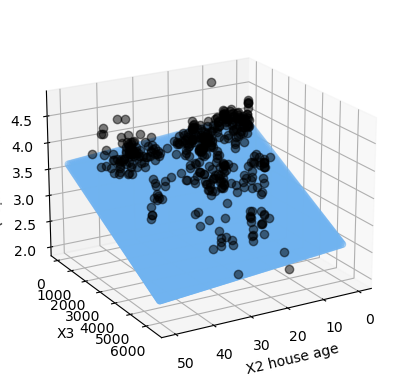

In [10]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X["X2 house age"], X["X3 distance to the nearest MRT station"],\
         y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), plt_predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax.view_init(elev=20, azim=60)
ax.set_xlabel("X2 house age")
ax.set_ylabel("X3")
ax.set_zlabel("log(house price)")

## Bayes Regression with pyro

Fitting Bayes Regression
[iteration 0300] loss: 1614.1400
[iteration 0600] loss: 1333.7434
[iteration 0900] loss: 1060.1736
[iteration 1200] loss: 789.7771
[iteration 1500] loss: 550.2462
[iteration 1800] loss: 357.8827
[iteration 2100] loss: 217.8329
[iteration 2400] loss: 125.9584
[iteration 2700] loss: 72.2084
[iteration 3000] loss: 44.5552
[iteration 3300] loss: 32.2615
[iteration 3600] loss: 27.6382
Learned parameters:
weight [[-0.0013261  -0.00021149]]
bias [3.786944]


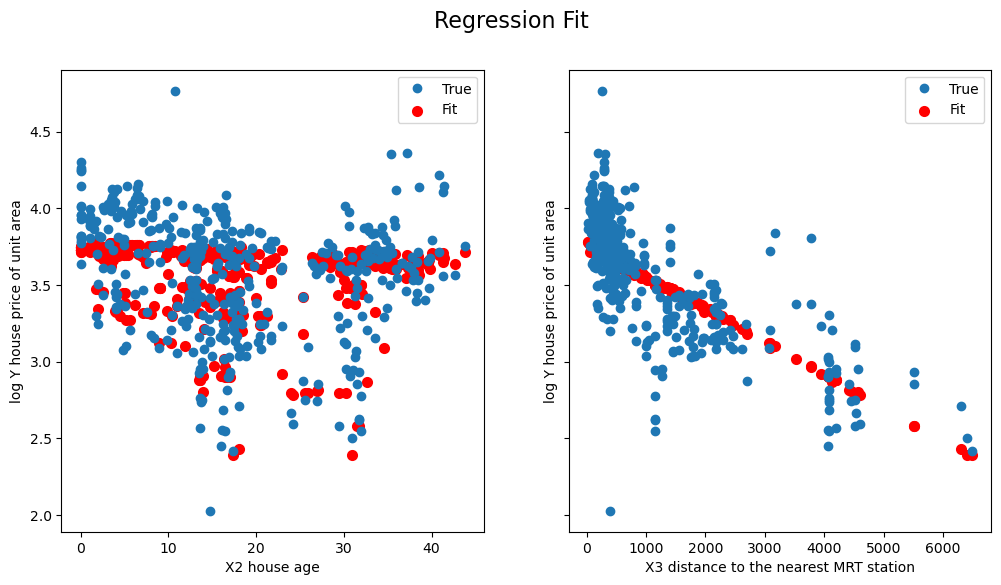

In [11]:
from svi_diagonal import ashish_bayes_regr
linear_reg_model,x_data,y_data = ashish_bayes_regr(X,y)

fit = real_estate.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(real_estate['X2 house age'], np.log(real_estate["Y house price of unit area"]), "o", label = "True")
ax[0].scatter(real_estate['X2 house age'], fit["mean"], linewidth=2,color="red", label= "Fit")
ax[0].set(xlabel="X2 house age",
          ylabel="log Y house price of unit area")
ax[0].legend()

ax[1].plot(real_estate['X3 distance to the nearest MRT station'],\
           np.log(real_estate["Y house price of unit area"]), "o", label = "True")
ax[1].scatter(real_estate['X3 distance to the nearest MRT station'], fit["mean"], linewidth=2,color="red", label= "Fit")
ax[1].set(xlabel="X3 distance to the nearest MRT station",
          ylabel="log Y house price of unit area")
ax[1].legend()

Text(0.5, 0, 'log(house price)')

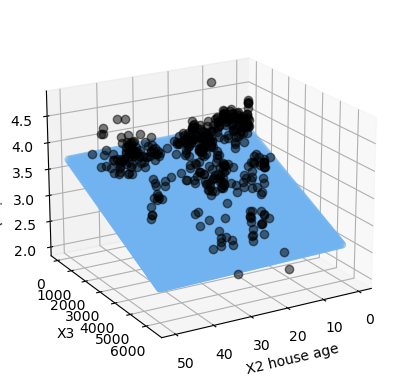

In [12]:
plt_predicted = linear_reg_model(torch.tensor(model_viz, dtype=torch.float)).detach().cpu().numpy()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(X["X2 house age"], X["X3 distance to the nearest MRT station"],\
         y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), plt_predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax.view_init(elev=20, azim=60)
ax.set_xlabel("X2 house age")
ax.set_ylabel("X3")
ax.set_zlabel("log(house price)")

### Bayesian Regression with Pyro's Stochastic Variational Inference (SVI)
AutoDiagonalNormal guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables

In [170]:
from svi_diagonal import ashish_bayes_regr_svi
samples,params_df = ashish_bayes_regr_svi(X,y,n_samples=340,NUM_ITER=5400)

Optimising ELBO loss
[iteration 0001] loss: 17175.9852
[iteration 0301] loss: 7.0548
[iteration 0601] loss: 61.6511
[iteration 0901] loss: 63.8351
[iteration 1201] loss: 43.4407
[iteration 1501] loss: 1.6850
[iteration 1801] loss: 4.7171
[iteration 2101] loss: 2.0058
[iteration 2401] loss: 9.2491
[iteration 2701] loss: 2.4573
[iteration 3001] loss: 28.0266
[iteration 3301] loss: 2.2259
[iteration 3601] loss: 2.0369
[iteration 3901] loss: 1.7892
[iteration 4201] loss: 13.5306
[iteration 4501] loss: 3.4967
[iteration 4801] loss: 3.6425
[iteration 5101] loss: 5.2875
Learned parameters:
AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.6367e+00, -8.2853e-03, -3.4943e-04,  3.9516e+00],
       requires_grad=True)
AutoDiagonalNormal.scale tensor([0.0550, 0.0116, 0.0014, 0.0637], grad_fn=<SoftplusBackward0>)
Quantiles for params
{'sigma': tensor([1.8617, 1.8664, 1.8709]), 'linear.weight': tensor([[[-0.0161, -0.0013]],

        [[-0.0083, -0.0003]],

        [[-0.0005,  0.0006]]]), 'linea

#### Density of Posterior params

Text(0.5, 0.98, 'Posterior Density of Regression parameters')

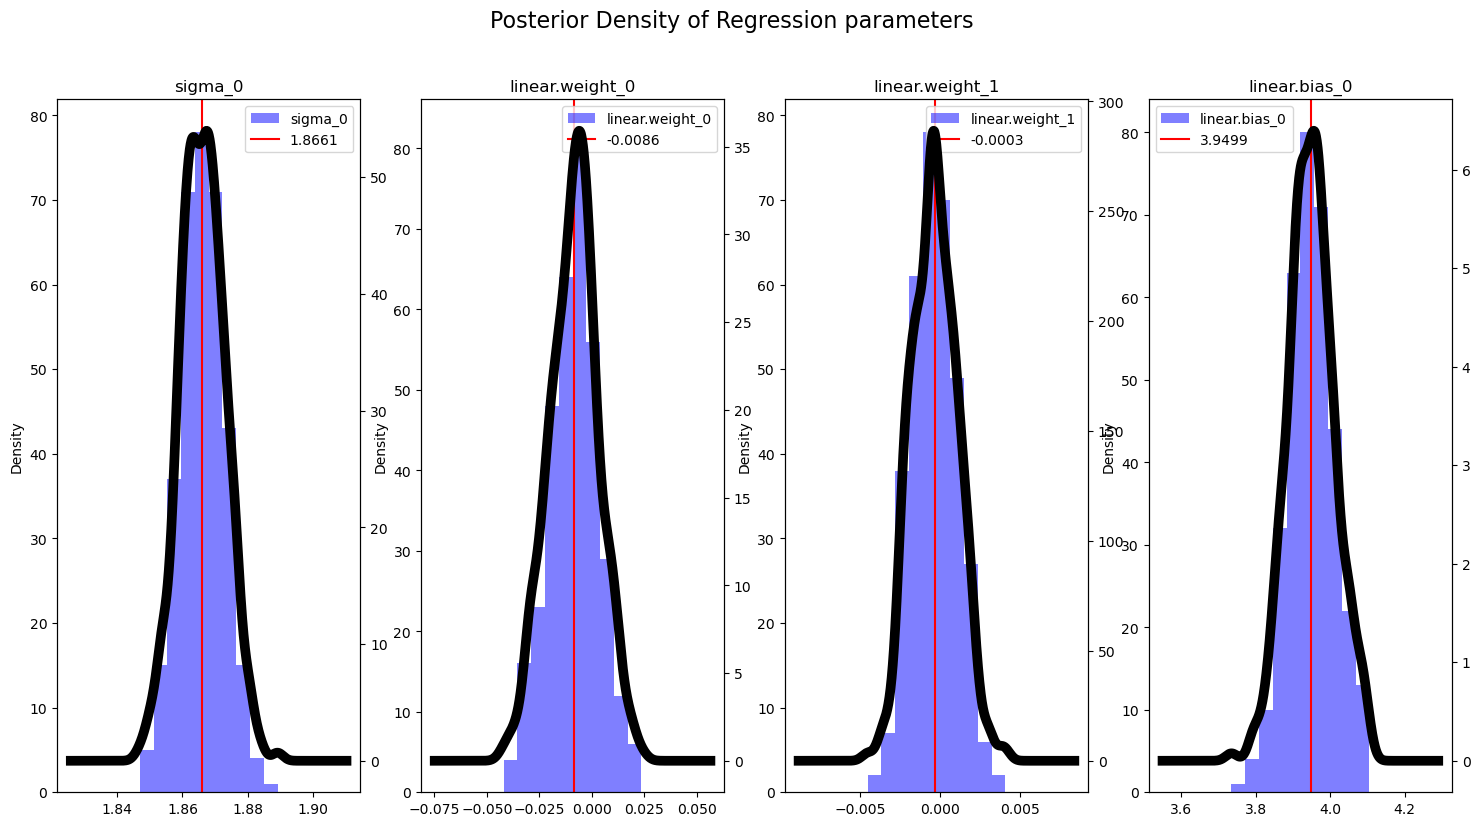

In [171]:
fig,ax = plt.subplots(1,len(params_df.columns),figsize=(18,9))
for i,param in enumerate(params_df.columns):
    params_df[param].plot.hist(ax=ax[i],color="blue",alpha=0.5)
    params_df[param].plot.kde(ax=ax[i],secondary_y=True,lw=7,color="black",bw_method=0.25)
    param_mean = params_df[param].mean()
    ax[i].axvline(param_mean,label=f"{param_mean:.4f}",color="red")
    ax[i].set_title(param)
    ax[i].legend()
    
fig.suptitle("Posterior Density of Regression parameters", fontsize=16)

#### Regression CI

In [172]:
def summary_np(samples):
    site_stats = {}
    for k, v in samples.items():
        v_np = v.numpy()
        site_stats[k] = {
            "mean": v_np.mean(axis=0),
            "std": v_np.std(axis=0),
            "25%": np.quantile(v_np,0.25,axis=0),
            "75%": np.quantile(v_np,0.75,axis=0),
        }
    return site_stats

pred_summary = summary_np(samples)

In [173]:
mu = pred_summary["_RETURN"]
y_hat = pred_summary["obs"]
predictions = pd.DataFrame({
    X.columns[0]: x_data[:, 0],
    X.columns[1]: x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_25": mu["25%"],
    "mu_perc_75": mu["75%"],
    "y_mean": y_hat["mean"],
    "y_perc_25": y_hat["25%"],
    "y_perc_75": y_hat["75%"],
    "log(house price)": y_data,
})

In [174]:
predictions

,X2 house age,X3 distance to the nearest MRT station,mu_mean,mu_perc_25,mu_perc_75,y_mean,y_perc_25,y_perc_75,log(house price)
0,32.000000,84.878822,3.647135,3.385963,3.907652,3.423619,2.158161,4.828593,3.634951
1,19.500000,306.594696,3.679979,3.329675,4.061405,3.648008,2.546238,4.784496,3.742420
2,13.300000,561.984497,3.647521,3.082345,4.245129,3.582970,2.032755,5.149493,3.856510
3,13.300000,561.984497,3.647521,3.082345,4.245129,3.473864,2.136351,4.807865,4.003690
4,5.000000,390.568390,3.776146,3.368022,4.183615,3.651746,2.337860,4.857272,3.763523
...,...,...,...,...,...,...,...,...,...
409,13.700000,4082.014893,2.464073,-1.749531,6.421594,2.489990,-1.435509,6.355238,2.734368
410,5.600000,90.456062,3.871607,3.769690,3.977766,3.957904,2.693444,5.181827,3.912023
411,18.799999,390.969604,3.657695,3.230746,4.095571,3.669328,2.383204,4.988496,3.703768
412,8.100000,104.810097,3.845364,3.721929,3.978097,3.738927,2.557286,4.873690,3.960813


Text(0, 0.5, 'y_mean')

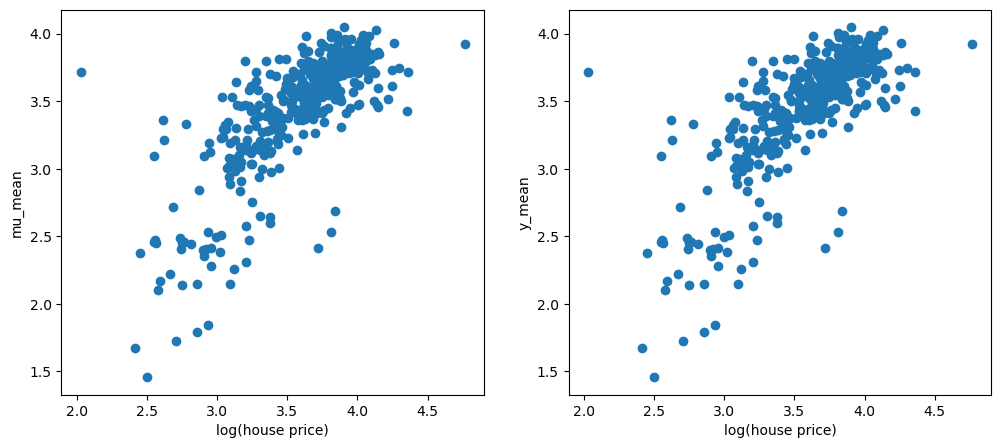

In [175]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(predictions["log(house price)"],predictions["y_mean"])
plt.xlabel("log(house price)")
plt.ylabel("mu_mean")
plt.subplot(122)
plt.scatter(predictions["log(house price)"],predictions["y_mean"])
plt.xlabel("log(house price)")
plt.ylabel("y_mean")

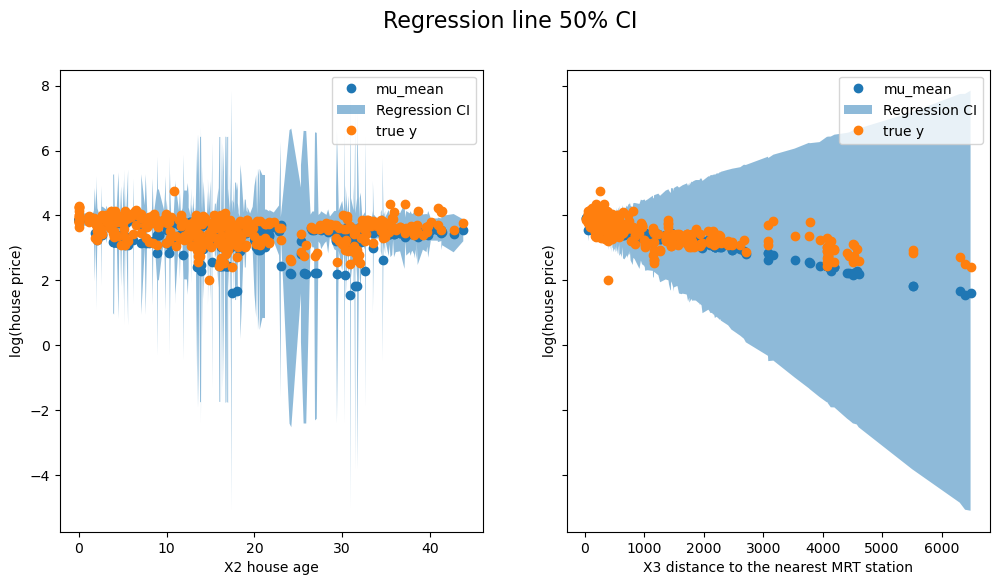

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

fig.suptitle("Regression line 50% CI", fontsize=16)

predictions1 = predictions.sort_values(by=["X2 house age"])
ax[0].plot(predictions1["X2 house age"],
           predictions1["mu_mean"],"o",label="mu_mean")
ax[0].fill_between(predictions1["X2 house age"],
                   predictions1["mu_perc_25"],
                   predictions1["mu_perc_75"],
                   alpha=0.5,interpolate=True,label="Regression CI")

ax[0].plot(predictions1["X2 house age"], 
           predictions1["log(house price)"],"o",label="true y")

ax[0].set(xlabel="X2 house age",
          ylabel="log(house price)")
ax[0].legend()

predictions2 = predictions.sort_values(by=["X3 distance to the nearest MRT station"])
ax[1].plot(predictions2["X3 distance to the nearest MRT station"],
           predictions2["mu_mean"],"o",label="mu_mean")
ax[1].fill_between(predictions2["X3 distance to the nearest MRT station"],
                   predictions2["mu_perc_25"],
                   predictions2["mu_perc_75"],
                   alpha=0.5,interpolate=True,label="Regression CI")

ax[1].plot(predictions2["X3 distance to the nearest MRT station"], 
           predictions2["log(house price)"],"o",label="true y")

ax[1].set(xlabel="X3 distance to the nearest MRT station",
          ylabel="log(house price)")
ax[1].legend()

In [182]:
((predictions["log(house price)"]>predictions["y_perc_25"]\
) & (predictions["log(house price)"]<predictions["y_perc_75"])).mean()

0.9975845410628019

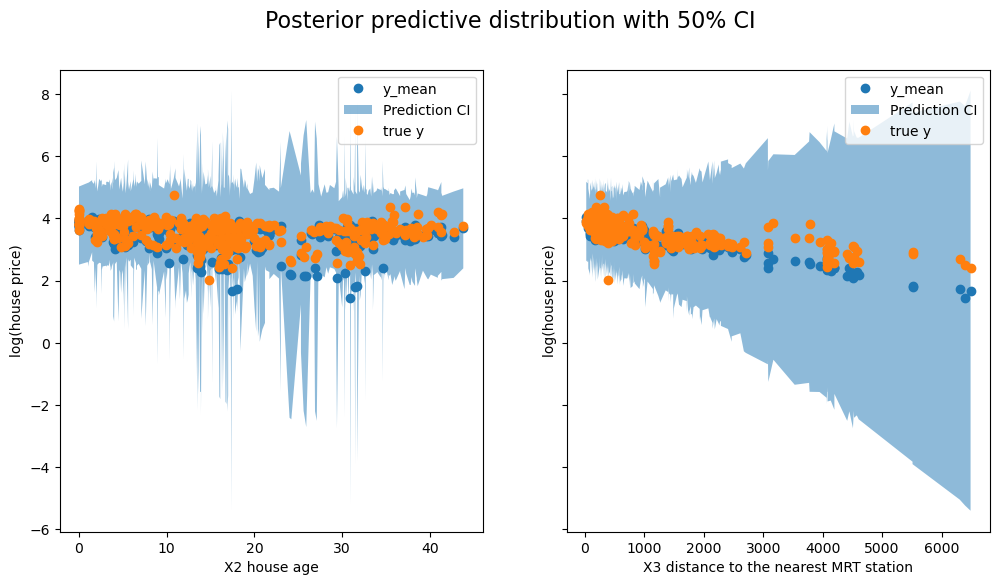

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 50% CI", fontsize=16)


predictions1 = predictions.sort_values(by=["X2 house age"])
ax[0].plot(predictions1["X2 house age"],
           predictions1["y_mean"],"o",label="y_mean")
ax[0].fill_between(predictions1["X2 house age"],
                   predictions1["y_perc_25"],
                   predictions1["y_perc_75"],
                   alpha=0.5,interpolate=True,label="Prediction CI")

ax[0].plot(predictions1["X2 house age"], 
           predictions1["log(house price)"],"o",label="true y")

ax[0].set(xlabel="X2 house age",
          ylabel="log(house price)")
ax[0].legend()


predictions2 = predictions.sort_values(by=["X3 distance to the nearest MRT station"])
ax[1].plot(predictions2["X3 distance to the nearest MRT station"],
           predictions2["y_mean"],"o",label="y_mean")
ax[1].fill_between(predictions2["X3 distance to the nearest MRT station"],
                   predictions2["y_perc_25"],
                   predictions2["y_perc_75"],
                   alpha=0.5,interpolate=True,label="Prediction CI")

ax[1].plot(predictions2["X3 distance to the nearest MRT station"], 
           predictions2["log(house price)"],"o",label="true y")

ax[1].set(xlabel="X3 distance to the nearest MRT station",
          ylabel="log(house price)")
ax[1].legend()

In [188]:
predictions.to_csv("./svi_diagonal_output/predictions_svi_diagonal_2cols.csv",index=None)

In [179]:
# predictions["X2 house age"].plot()